# Guava Disease Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extracting dataset from .zip

In [4]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Guava Disease( Augmented Image).zip'
extract_path = '/content/extracted/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Import all the Dependencies

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4899 files belonging to 5 classes.


In [9]:
class_names = dataset.class_names
class_names

['Disease Free', 'Phytopthora', 'Red_Rust', 'Scab', 'Styler and Root']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 1 2 4 4 2 1 0 4 2 4 4 4 3 2 1 4 3 2 1 2 2 1 0 1 2 3 2 4 1 0 1]


### Visualize some of the images from our dataset

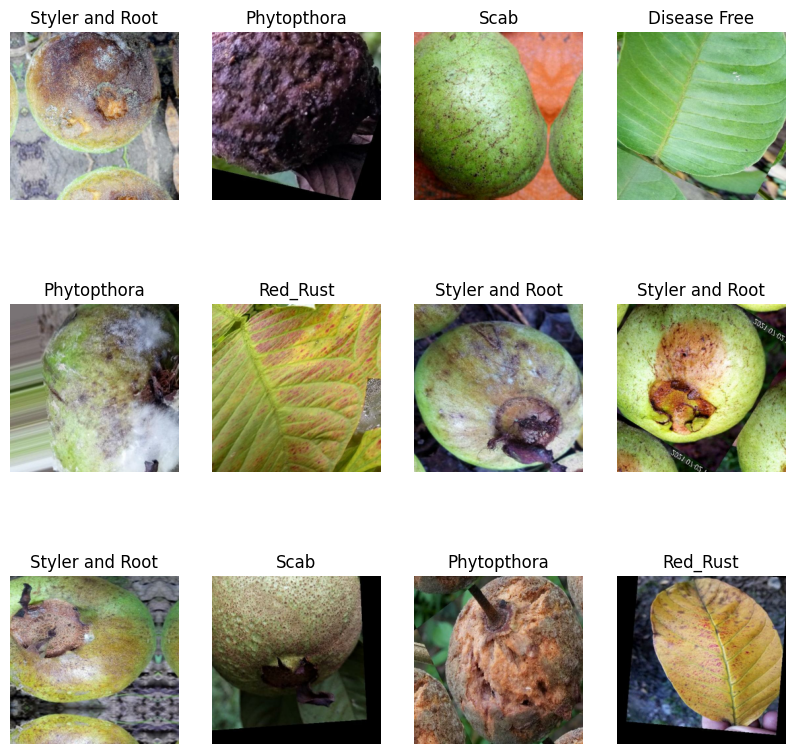

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

### Splitting Dataset
We are splitting dataset in 80:10:10 from train test and validation.

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

### Calling the spit function

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
filepath = "grapes.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=2, verbose=1)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[es, ckpt, rlp],
)

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 1.2654 - accuracy: 0.4497
Epoch 1: loss improved from inf to 1.26539, saving model to grapes.h5
123/123 [==============================] - 67s 400ms/step - loss: 1.2654 - accuracy: 0.4497 - val_loss: 0.9091 - val_accuracy: 0.6167 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


123/123 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.6642
Epoch 2: loss improved from 1.26539 to 0.84505, saving model to grapes.h5
123/123 [==============================] - 37s 303ms/step - loss: 0.8451 - accuracy: 0.6642 - val_loss: 0.6737 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.7379
Epoch 3: loss improved from 0.84505 to 0.68139, saving model to grapes.h5
123/123 [==============================] - 37s 300ms/step - loss: 0.6814 - accuracy: 0.7379 - val_loss: 0.5793 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 4/50
123/123 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7796
Epoch 4: loss improved from 0.68139 to 0.57574, saving model to grapes.h5
123/123 [==============================] - 37s 299ms/step - loss: 0.5757 - accuracy: 0.7796 - val_loss: 0.7033 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 5/50
123/123 [==============================] - ETA: 0

In [34]:
scores = model.evaluate(test_ds)

16/16 [==============================] - 10s 25ms/step - loss: 0.0575 - accuracy: 0.9844


In [35]:
scores

[0.057512328028678894, 0.984375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 123}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [39]:
type(history.history['loss'])

list

In [40]:
len(history.history['loss'])

32

In [41]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2653870582580566,
 0.8450533151626587,
 0.6813891530036926,
 0.5757405757904053,
 0.4667273461818695]

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

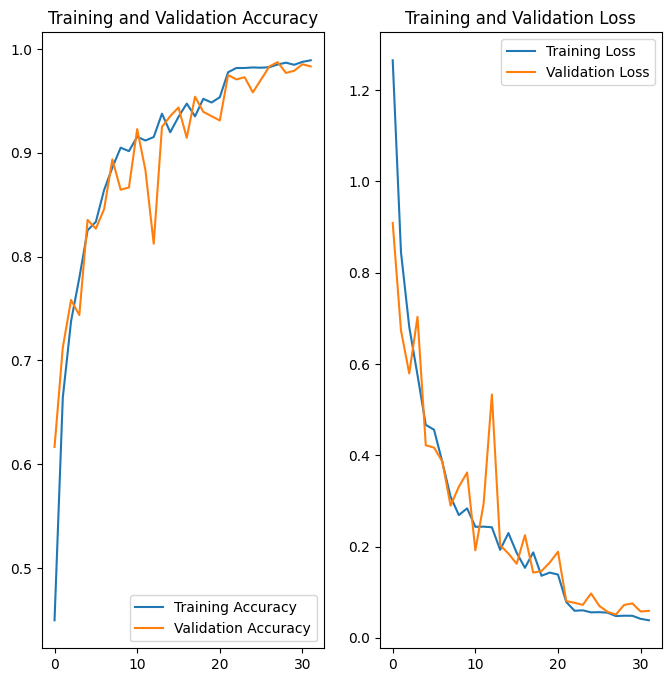

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(32), acc, label='Training Accuracy')
plt.plot(range(32), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(32), loss, label='Training Loss')
plt.plot(range(32), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Red_Rust
1/1 [==============================] - 0s 33ms/step
predicted label: Red_Rust


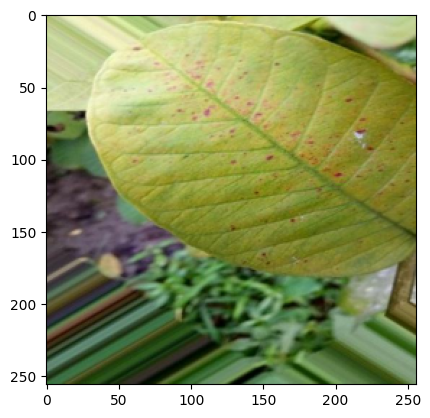

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 18ms/step


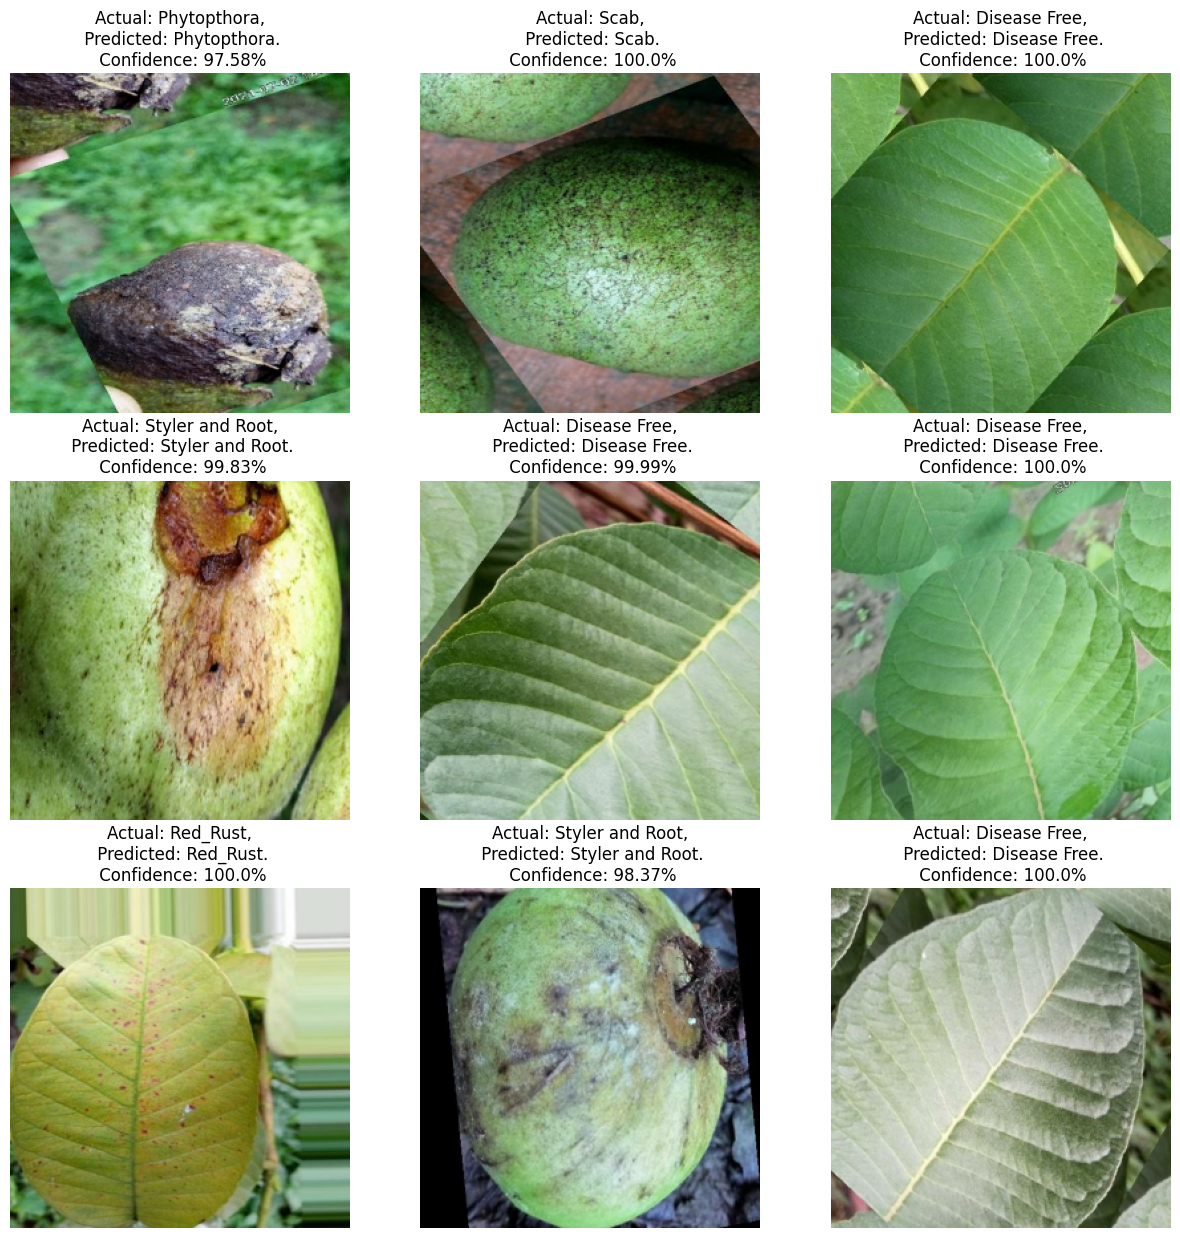

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")